# Springboard Data Science Career Track Program

## Capstone Project 1 - DonorsChoose Final Report

#### Irene Yao
#### December 11, 2018

### <font color=#3090C7>INTRODUCTION</font>

DonorsChoose.org is a non-profit education crowdfunding platform that allows individuals to donate directly to public school classroom projects. Since its inception in 2000, the organization has helped to fund more than 1,200,000 projects which reached out to more than 31,000,000 students. In this project, we will be diving into the datasets collected from DonorsChoose.org’s open data platform to explore an assortment of factors that may affect the project’s success rate. In addition, we will perform a donor clustering using a similarity measure to produce groupings of donors. With the analysis, we are hoping to help the organization to observe the shared features among different donors and projects and potentially find an approach to better match its projects with the most relevant donor groups.

### <font color=#3090C7>DESCRIPTION OF DATASET</font>

This analysis is based on public data from DonorsChoose.org’s open data platform. The datasets used include the Project data and the Donation data, which are downloaded separately and merged together using the _projectid column. The joined table contains more than 6 million entries (rows), each refers to an individual donation made toward a certain project. The _donationid is the unique key of each entry. 

### <font color=#3090C7>DATA WRANGLING</font>

1. *Feature Selection:* I started with features selected from the data and pruned the variables to only include the relevant columns.     
  
  
2. *Memory Optimization:* After inspecting the data table by performing df.info(memory_usage='deep'), we noticed that the biggest problem with the dataset is that it consumes more than 12.9GB of memory. The data frame has 3 data types: float, integer and object. The object type data is the one that consumes the most memory. Since most of the object data are categorical data in our dataset, converting them to the type 'category' will save a lot of memory. However, we don't want to convert all the object columns to 'category' if they don't have a few unique values. As a result, we only want to convert columns where less than 50% of the values are unique. After the optimization, we observed that the memory usage decreased from 12.9GB to 2GB.


3. *Filling in Missing Values:* There are some missing values in the school_city column. This is the location of the school raising funds for a project. To fill in the missing values, I map the city according to the corresponding school district. However, some of the school districts cover more than one city. Thus, we cannot infer the corresponding city from the district name. By applying the above mapping, we were able to decrease the null value in the school_city column from more than 50,000 to 12,673.


4. *Save the Optimized Data:* the optimized dataset after data wrangling was saved as a pickled file for easy extraction for future use. 



### <font color=#3090C7>EXPLORATORY DATA ANALYSIS & STATISTICAL ANALYSIS</font>

The exploratory data analysis (EDA) provides insights from different perspectives including donations, projects, teachers, and how the user base grew over time. To make the analysis more relevant to the US market, we will only look at donations that happened in US. The below codes extract the US donations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline  
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('project_donation_optimized.pkl')

In [3]:
## get US dataset by mapping the states
xl = pd.ExcelFile('state_long_lat.xlsx')
lon_lat_map = xl.parse('state_long_lat')
us_states = lon_lat_map['State_Short']
df_us = df[(df['donor_state'].notnull()) & (df['donor_state'].isin(us_states))]

### Donation Analysis

##### Donors & Donations

To start with, we will run some general numbers from the dataset including total number of donors and donations to see how many donors are actively using the website to make contributions. The data shows that as of October 2016, there are 1,786,756 registered donors on the platform, who have made a total contribution of $362,873,020.

In [4]:
## total number of donors
donor_number = df_us['_donor_acctid'].nunique()
total_donation = df_us['donation_total'].sum()
print("As of October 2016, there are " + 
      str(donor_number) + 
      """ registered donors on DonorsChoose, who have made a total contribution of """ + 
      str(total_donation) + " dollars.")

As of October 2016, there are 1786756 registered donors on DonorsChoose, who have made a total contribution of 362873020.0 dollars.


Next, I would love to see among all the users, how many are multiple-time donors versus single-time donors. I will show a bar graph which depicts the count for each donation frequency. 

In [5]:
donation_count = df_us.groupby('_donor_acctid').size().to_frame().reset_index()
donation_count.columns = ['donor_id', 'donation_count']
#donation_count.head()
donation_freq = donation_count['donation_count'].value_counts(ascending=False).to_frame().reset_index()
donation_freq.columns = ['donation_frequency', 'count']
donation_freq.head()

,donation_frequency,count
0,1,1318268
1,2,250701
2,3,85637
3,4,40662
4,5,23093


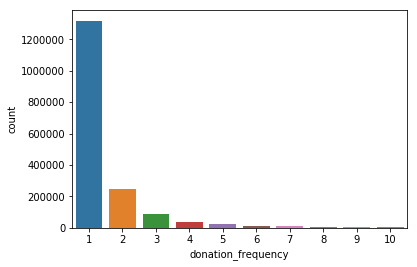

In [6]:
sns.barplot(x='donation_frequency', y='count', data=donation_freq.head(10))

As shown above, out of the 1,786,756 donors, majority (1,318,268) of them have only donated once, and only 26% are frequent donors.

##### Donation Distribution

It is interesting to see how different states are using the service and where the donations are concentrated. This can be reflected in both the number of donations and total donation amount in each state.

In [7]:
donor_state_count = df_us.groupby(df_us['donor_state'].astype('object')).size().sort_values(ascending=False)
max_donor_state = donor_state_count.head(10)
min_donor_state = donor_state_count.tail(10)

In [8]:
state_don_amt = df_us.groupby(df_us['donor_state'].astype('object'))['donation_total'].sum().sort_values(ascending=False)
max_state_amt = state_don_amt.head(10)
min_state_amt = state_don_amt.tail(10)

Text(0, 0.5, 'Amount')

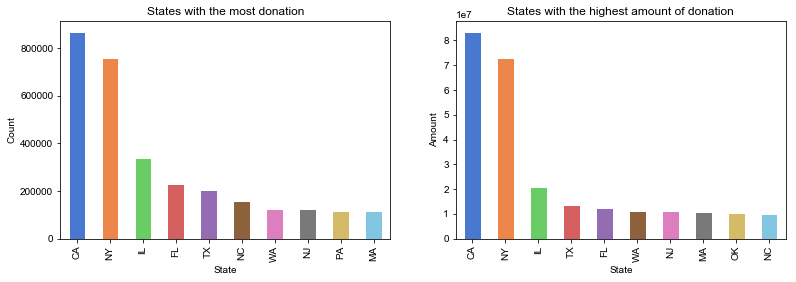

In [9]:
### states with the most donation
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
sns.set_style('white')
sns.set_palette('muted')
ax0.set_title('States with the most donation')
ax1.set_title('States with the highest amount of donation')
max_donor_state.plot.bar(ax=ax0)
max_state_amt.plot.bar(ax=ax1)
ax0.set_xlabel('State')
ax0.set_ylabel('Count')
ax1.set_xlabel('State')
ax1.set_ylabel('Amount')

Text(0, 0.5, 'Amount')

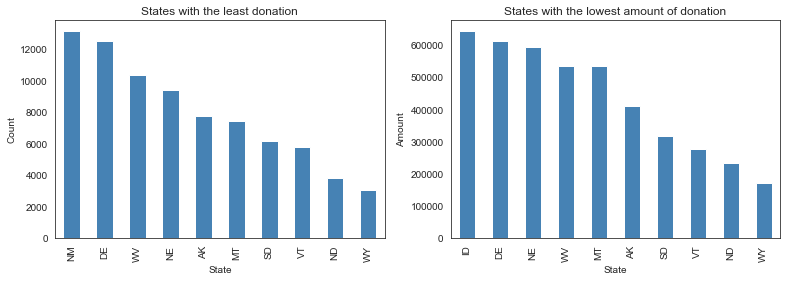

In [10]:
### states with the least donation
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
sns.set_style('white')
ax0.set_title('States with the least donation')
ax1.set_title('States with the lowest amount of donation')
min_donor_state.plot.bar(ax=ax0, color='steelblue')
min_state_amt.plot.bar(ax=ax1, color='steelblue')
ax0.set_xlabel('State')
ax0.set_ylabel('Count')
ax1.set_xlabel('State')
ax1.set_ylabel('Amount')

We can see from above that among all the states, California and New York rank as the top 2 states with respect to amount donated and number of projects for which donations were sent. However, the top states are also the states with the largest population. I suspect that there is a positive correlation between number of donations and state population. I will add the population data obtained from the Census Bureau, which includes the population of each state as of 2016.
Population data: https://www2.census.gov/programs-surveys/popest/datasets/2010-2017/state/asrh/

In [11]:
## get US population data
state_map = dict(zip(lon_lat_map['State'], lon_lat_map['State_Short']))
pop_df = pd.read_csv('population_data.csv')
pop_2016 = pop_df[['NAME', 'POPESTIMATE2016']]
pop_2016 = pop_2016.loc[5:55]
pop_2016 = pop_2016[pop_2016['NAME']!='District of Columbia']
pop_2016.columns = ['State', '2016_Population']
pop_2016['State_Short'] = pop_2016['State'].map(state_map)
pop_map = dict(zip(pop_2016['State_Short'], pop_2016['2016_Population']))
#pop_2016.head()

(0, 1269416.634981715)

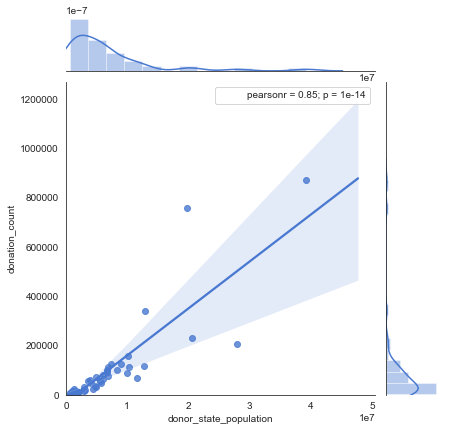

In [12]:
df_us['donor_state_population'] = df_us['donor_state'].map(pop_map)
don_pop = df_us.groupby(['donor_state', 'donor_state_population'])['donor_state'].size()
don_pop = don_pop.to_frame()
don_pop.columns = ['donation_count']
don_pop = don_pop.reset_index()

g = sns.jointplot('donor_state_population', 'donation_count', data=don_pop, kind='reg')
g.annotate(stats.pearsonr)
plt.xlim(left=0)
plt.ylim(bottom=0)

The joint plot above demonstrates a strong positive correlation between the state population and the number of donations from the state with a pearson correlation r equals 0.85. The small p-value suggests the strong evidence that the correlation is statistically significant. Therefore, we can conclude that more donations are collected from states with a larger population.

Since we know that the population is associated with the number of donations, it would be more intuitive to compare the per capita donation within the state instead of total number of donations. We would add a donation_ratio column and investigate if there's any difference among different states.

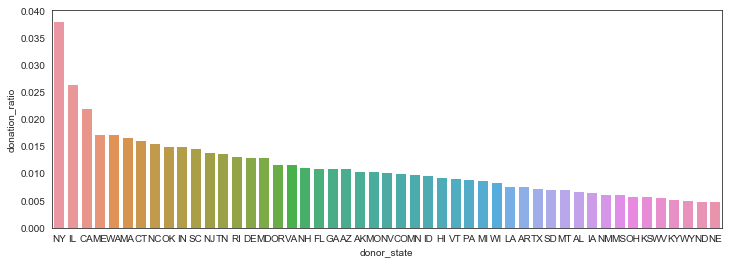

In [13]:
don_pop['donation_ratio'] = (don_pop['donation_count']/don_pop['donor_state_population'])
don_state = don_pop[['donor_state', 'donation_ratio']].sort_values('donation_ratio', ascending=False)
plt.figure(figsize=(12,4))
sns.barplot(x='donor_state', y='donation_ratio', data=don_state, order=don_state['donor_state'])

In [14]:
don_pop[don_pop['donation_ratio']>=0.02]

,donor_state,donor_state_population,donation_count,donation_ratio
4,CA,39296476.0,869925,0.022137
13,IL,12835726.0,339851,0.026477
33,NY,19836286.0,757193,0.038172


After calculating the donations on a per capita basis, we can still observe the difference among states. In fact, New York, Illinois, and California are still the top 3 states with the highest per capita donation.

### Project Analysis

##### Count & Amount

In [15]:
print(df_us['_projectid'].nunique())
print(df_us['date_posted'].max())

924255
2016-10-11 00:00:00


As of October 2016, there are in total 924,255 projects posted on the website. In order to see how the number of projects has grown over time, we will break the numbers down into different years. We also notice that for the projects posted on the platform, they can either be completed or expired without enough donation. We would also like to see the trends in fully-funded projects.

In [16]:
df_us['project_year'] = df_us['date_posted'].dt.year
df_us['complete_year'] = df_us['date_completed'].dt.year

In [17]:
### projects posted over time
project_over_time = df_us.groupby('project_year')['_projectid'].nunique()
completed_projects = df_us[df_us['funding_status']=='completed']
completed_over_time = completed_projects.groupby('complete_year')['_projectid'].nunique()

Text(0, 0.5, 'Count')

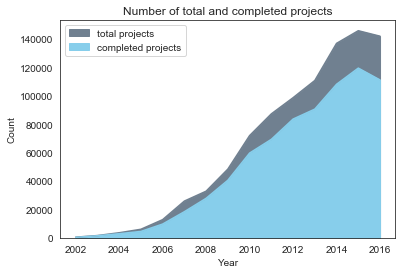

In [18]:
sns.set_style('white')
fig, ax = plt.subplots()
project_over_time.plot.area(ax=ax, label='total projects', color='slategrey')
completed_over_time.plot.area(ax=ax, label='completed projects',color='skyblue')
ax.set_title('Number of total and completed projects')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Count')

The project flow started to pick up in a fast pace starting around year 2006. A quick research on the company's Wikipedia page reveals that the organization has been given Charity Navigator's highest rating every year since 2005. This corresponds to the high growth path explained in the chart.

Now we have an idea of the project volume, let's take a look at the donation amount associated with each project. We will identify the projects with the most donation count, highest donation amount, and the average donation of all the completed projects.

In [19]:
## project donation size
total_donation_per_project = completed_projects.groupby('_projectid')['donation_total'].sum()
total_donation_per_project = total_donation_per_project.sort_values(ascending=False)
average_donation = total_donation_per_project.mean()
average_donation

457.025634765625

In [20]:
## max donation size
print('highest donation amount: ' + str(total_donation_per_project.max()))
print('max number of donation: ' + str(completed_projects['num_donors'].max()))

highest donation amount: 186951.77
max number of donation: 848


In [21]:
print(total_donation_per_project.sort_values(ascending=False).head(1))

_projectid
bbbc6cccccd3c1bc8c44ec494bb6cf23    186951.765625
Name: donation_total, dtype: float32


In [22]:
completed_projects[completed_projects['_projectid']=='bbbc6cccccd3c1bc8c44ec494bb6cf23'].head(2)

,_donationid,_projectid,_donor_acctid,donor_city,donor_state,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,payment_method,is_teacher_referred,thank_you_packet_mailed,_teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,donor_state_population,project_year,complete_year
254134,01d72050cfc5714eb5f9bde7f2a1e2f0,bbbc6cccccd3c1bc8c44ec494bb6cf23,4242433cbedd23bf0f4f3ff22eb17ccc,NaN,OR,0,2015-12-03 14:04:45.633,425.00,75.00,500.0,paypal,0,f,ba835ad62be9d5f38b2e54a8edbf83fb,NaN,40.839062,-73.900124,New York City,NY,10457.0,urban,New York Dept Of Education,Bronx,Mr.,Gym & Fitness,Health & Sports,NaN,NaN,Supplies,highest poverty,Grades 3-5,217377.015625,255737.671875,999.0,249253.3125,313,t,f,completed,2015-08-28,2015-12-28,NaT,2016-01-29,4085989.0,2015,2015.0
254136,01dd0a7985b986793d9d6ae6204023b0,bbbc6cccccd3c1bc8c44ec494bb6cf23,0e210f62f3f0cb27598664a7f0116b09,NaN,NY,0,2015-12-01 23:38:29.281,21.25,3.75,25.0,creditcard,0,f,ba835ad62be9d5f38b2e54a8edbf83fb,NaN,40.839062,-73.900124,New York City,NY,10457.0,urban,New York Dept Of Education,Bronx,Mr.,Gym & Fitness,Health & Sports,NaN,NaN,Supplies,highest poverty,Grades 3-5,217377.015625,255737.671875,999.0,249253.3125,313,t,f,completed,2015-08-28,2015-12-28,NaT,2016-01-29,19836286.0,2015,2015.0


In [23]:
completed_projects[completed_projects['num_donors']==848]
completed_projects[completed_projects['_projectid']=='c34218abf3fecd36be01305d67ed7fbb'].head(2)

,_donationid,_projectid,_donor_acctid,donor_city,donor_state,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,payment_method,is_teacher_referred,thank_you_packet_mailed,_teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,donor_state_population,project_year,complete_year
17863,0009d2759ff78b89a8b85b95ffc1e921,c34218abf3fecd36be01305d67ed7fbb,9437d67acc13a0643c8667c019602b9d,NaN,CA,0,2015-05-29 01:04:07.193,84.150002,14.85,99.0,creditcard,1,f,7fe6dd0c1af5f911e9bc38030cfb4ced,6.112201e+10,38.006054,-122.552521,San Rafael,CA,94903.0,suburban,Dixie School District,Marin,Ms.,Health & Wellness,Health & Sports,Literacy,Literacy & Language,Supplies,moderate poverty,Grades 3-5,93563.90625,110075.1875,350.0,109333.476562,848,f,f,completed,2015-05-26,2015-08-12,2015-12-21,2015-10-24,39296476.0,2015,2015.0
17864,0019498f1881b4ab7462e92a08df5c14,c34218abf3fecd36be01305d67ed7fbb,306961a477a046e184d4e708f718111f,NaN,PA,0,2015-06-25 08:53:17.245,40.000000,0.00,40.0,creditcard,1,f,7fe6dd0c1af5f911e9bc38030cfb4ced,6.112201e+10,38.006054,-122.552521,San Rafael,CA,94903.0,suburban,Dixie School District,Marin,Ms.,Health & Wellness,Health & Sports,Literacy,Literacy & Language,Supplies,moderate poverty,Grades 3-5,93563.90625,110075.1875,350.0,109333.476562,848,f,f,completed,2015-05-26,2015-08-12,2015-12-21,2015-10-24,12787085.0,2015,2015.0


The average donations per project is around `$`450. The project with the highest donation amount is a project completed in 2015. It was posted by a teacher in New York City to raise funds for gyms and fitness purpose. The project was sponsored by 313 donors with a total donation amount of `$`186,951.77. The project with the most number of donors is a project for an elementary school in San Rafael, CA. The funds are used to support Literacy development and raised `$`93,563.91 from 848 donors.

With the drastic growth in number of posted projects, it would be important to also measure the turnaround rate. I am curious to know whether it's taking longer or shorter for each project to be completed.

In [24]:
### average time for projects to be completed
df_complete = df_us[df_us['funding_status']=='completed']
df_complete['days_to_complete'] = (df_complete['date_completed']-df_complete['date_posted']).dt.days
df_complete= df_complete[['_projectid', 'project_year', 'days_to_complete']].drop_duplicates()

In [25]:
#df_complete.head()
df_complete_nan = df_complete.dropna()

In [26]:
average_completion_days = df_complete.groupby('project_year')['days_to_complete'].mean()
#average_completion_days.values

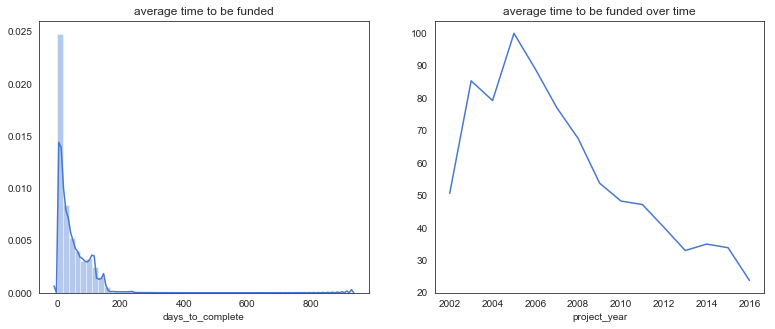

In [27]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
sns.set_style('white')
ax0.set_title('average time to be funded')
ax1.set_title('average time to be funded over time')
sns.distplot(df_complete_nan['days_to_complete'], ax = ax0)
sns.lineplot(x=average_completion_days.index, y=average_completion_days.values, ax = ax1)

The majority of the projects are fully-donated within 100 days, and the turnaround keeps decreasing with more and more people starting using the platform. The projects that are posted recently were completed within around a month.

##### Project Completion Time vs. Primary Focus Area

DonorsChoose placed projects into 7 different focus areas. The following analysis compares the duration for completing the donations among different categories. Since the platform wasn't getting a lot of volume before 2006, the projects posted back then created many outliers in terms of completion time. For the analysis purpose, I will only use the projects posted between 2006 and 2016.

In [28]:
### average time for projects to be completed - project focus
df_complete_recent = df_us[(df_us['funding_status']=='completed') & (df_us['date_posted']>='2006-01-01')]
df_complete_recent['days_to_complete'] = (df_complete_recent['date_completed']-df_complete_recent['date_posted']).dt.days
df_complete_recent= df_complete_recent[['_projectid', 'primary_focus_area', 'days_to_complete', 'donation_total']].drop_duplicates()
mean_comp_days = df_complete_recent.groupby('primary_focus_area')['days_to_complete'].mean()
print(mean_comp_days)

primary_focus_area
Applied Learning       43.045365
Health & Sports        35.078756
History & Civics       41.731956
Literacy & Language    42.343375
Math & Science         40.364388
Music & The Arts       43.296106
Special Needs          43.593827
Name: days_to_complete, dtype: float64


The means look similar among different subjects. I'll do a Tukey’s Range Test to see if the means are actually the same.

H0: the mean time it takes to complete the donation for reach subject area is the same.

HA: there is a significant difference in the mean time to complete the donation among different subject areas.


In [29]:
df_complete_recent = df_complete_recent.dropna()
v = df_complete_recent['days_to_complete']
labels = df_complete_recent['primary_focus_area']

### Tukey
tukey_results = pairwise_tukeyhsd(v, labels, 0.05)
print(tukey_results)

           Multiple Comparison of Means - Tukey HSD,FWER=0.05          
       group1              group2       meandiff  lower   upper  reject
-----------------------------------------------------------------------
  Applied Learning    Health & Sports   -7.9666   -8.49  -7.4432  True 
  Applied Learning    History & Civics  -1.3134  -1.8376 -0.7892  True 
  Applied Learning  Literacy & Language  -0.702  -1.0581 -0.3458  True 
  Applied Learning     Math & Science    -2.681  -3.0514 -2.3105  True 
  Applied Learning    Music & The Arts   0.2507  -0.1726  0.6741 False 
  Applied Learning     Special Needs     0.5485   0.0872  1.0097  True 
  Health & Sports     History & Civics   6.6532   6.0807  7.2257  True 
  Health & Sports   Literacy & Language  7.2646   6.8406  7.6887  True 
  Health & Sports      Math & Science    5.2856   4.8495  5.7217  True 
  Health & Sports     Music & The Arts   8.2174   7.7355  8.6992  True 
  Health & Sports      Special Needs     8.5151   7.9996  9.0305

Text(33.99999999999999, 0.5, '')

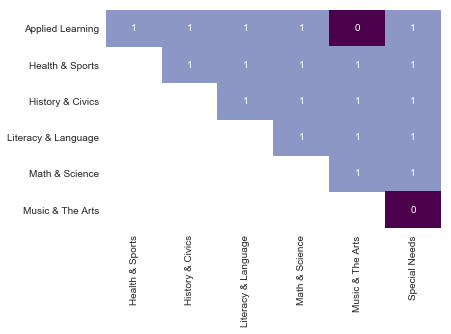

In [30]:
subjects = tukey_results.groupsunique
groups=[]
for i in range(len(subjects)):
    for j in range(i+1, len(subjects)):
        groups.append((subjects[i], subjects[j]))
groups_df = pd.DataFrame(groups)
groups_df.columns=['Group1', 'Group2']
groups_df['Reject'] = tukey_results.reject
groups_df['Reject'] = [1 if i==True else 0 for i in groups_df['Reject']]
groups_df_pivot = groups_df.pivot('Group1', 'Group2', 'Reject')
ax = sns.heatmap(groups_df_pivot, cmap='BuPu_r', center=1, cbar=False, annot=True)
plt.xlabel('')
plt.ylabel('')

The Tukey test suggests that in most cases, we can reject the null hypothesis and conclude that the difference in mean time to complete the donation in different subject areas is statistically significant.    
(The grid with number 0 means that we cannot reject the null hypothesis and the grid with number 1 means that the null hypothesis can be rejected.)

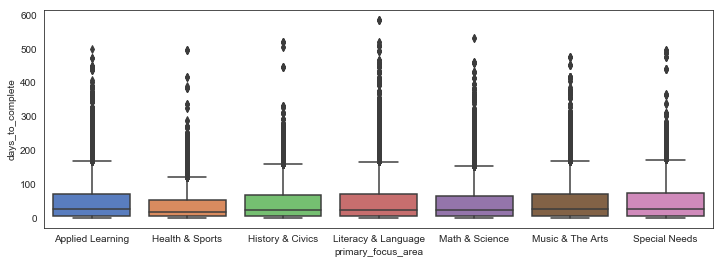

In [31]:
plt.figure(figsize=(12,4))
sns.boxplot(x='primary_focus_area', y='days_to_complete', data=df_complete_recent)

Health & Sports has the lowest mean and the narrowest interquartile range. It is the category that requires the least time to collect donation. 

##### Projects vs. Grade Levels

The projects are raised for schools from PreK to grade 12. From the below chart, it is clear that most of the fundings are demanded in elementary level, especially among lower grades.

In [32]:
projects_grade = df_us.groupby('grade_level')['_projectid'].nunique()

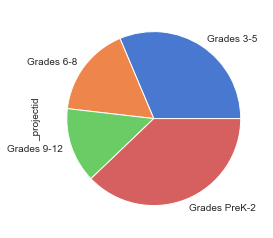

In [33]:
sns.set_style('white')
sns.set_palette('muted')
fig, ax = plt.subplots(1, 1)
ax.set_ylabel('')
projects_grade.plot(kind='pie', ax=ax)

##### Projects vs. Poverty Level

In [34]:
projects_pov = df_us.groupby('poverty_level')['_projectid'].nunique()

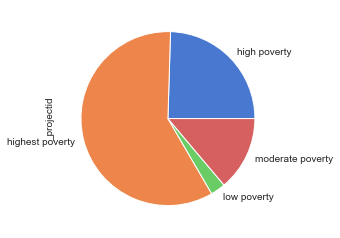

In [35]:
sns.set_style('white')
sns.set_palette('muted')
projects_pov.plot(kind='pie')

It makes sense that more donations are needed where the poverty level is high with limited government funding. 

##### Projects vs. Focus Area

With the current trends in tech development, schools are focusing more on technology-related education such as STEM. To see if the donation requests match the trend, we will divide the projects into different subject areas.

In [36]:
project_focus_area = df_us.groupby('primary_focus_area')['_projectid'].nunique().sort_values(ascending=False)

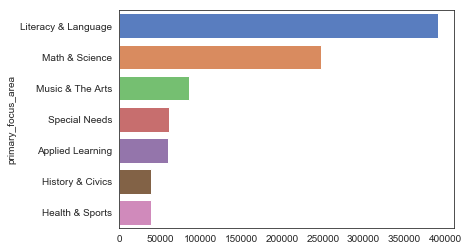

In [37]:
sns.set_palette('muted')
sns.barplot(x=project_focus_area.values, y=project_focus_area.index, order=project_focus_area.index)

Indeed, teachers are requesting more support in Literacy & Language and Math & Science categories. But was this the trend since the beginning?

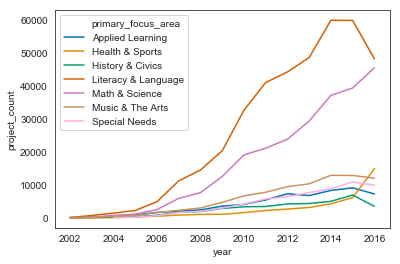

In [38]:
project_focus_area = df_us.groupby(['project_year','primary_focus_area'])['_projectid'].nunique()
project_focus_area = project_focus_area.to_frame().reset_index()
project_focus_area.columns = ['year', 'primary_focus_area', 'project_count']
sns.set_palette('colorblind')
sns.lineplot(data=project_focus_area, x='year', y='project_count', hue='primary_focus_area')

While all projects exhibit an upward trend, demand in Math & Science and Literacy & Language have grown more rapidly than the rest. While most of the projects have started to slow down since 2015, projects in Math & Science continued to expand. Let’s take a look at the pattern when we break down the data by poverty level.

In [39]:
focus_poverty = df_us.groupby(['primary_focus_area', 'poverty_level'])['_projectid'].nunique()
focus_poverty = focus_poverty.to_frame().reset_index()
focus_poverty.head()

,primary_focus_area,poverty_level,_projectid
0,Applied Learning,high poverty,14880
1,Applied Learning,highest poverty,35671
2,Applied Learning,low poverty,1595
3,Applied Learning,moderate poverty,7892
4,Health & Sports,high poverty,9673


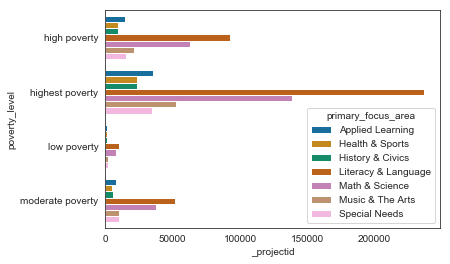

In [40]:
sns.barplot(x='_projectid', y='poverty_level', hue='primary_focus_area', data=focus_poverty)

Despite different wealth levels among schools, Literacy & Language and Math & Science are always on the top of the bucket list.

### Teacher Analysis

The projects on the platform are teacher-driven. Let's first take a look at the total teacher population over years.

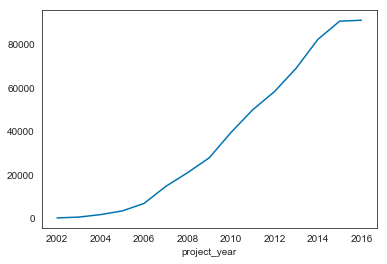

In [41]:
teacher_count = df_us.groupby('project_year')['_teacher_acctid'].nunique()
teacher_count
sns.set_style('white')
teacher_count.plot()

Teacher users have more than doubled from year 2010 to 2016. It exhibits a positive correlation with the project growth.

Next, I would like to see how many projects are posted by female teachers vs. male teachers.

In [42]:
df_us['teacher_gender'] = ['Female' if i in ['Mrs.', 'Ms.'] else 'Male' if i=='Mr.' else 'Unknown' for i in df_us['teacher_prefix']] 

In [43]:
## number of teachers posting projects over years
teacher_over_time = df_us.groupby(['project_year', 'teacher_gender'])['_teacher_acctid'].nunique()
teacher_over_time = teacher_over_time.to_frame().reset_index()
teacher_over_time.columns = ['year', 'teacher_gender', 'teacher_count']
#teacher_over_time

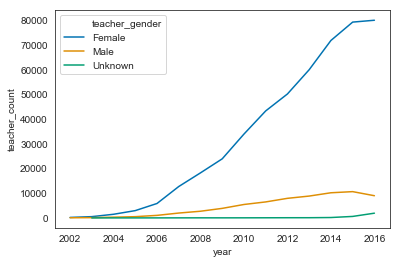

In [44]:
sns.lineplot(data=teacher_over_time, x='year', y='teacher_count', hue='teacher_gender')

We can spot that the number of male teachers grew very little and majority of the projects are posted by female teachers. That's probably because female are more prevalent in teaching positions. 

Would the teacher's gender have any influence on the success rate of the project completion? We will conduct a hypothesis testing by applying the Chi-square test. 


H0: there is no difference in the donation completion rate between male and female teachers

H1: there is a significant difference in the donation completion rate between male and female teachers

Significance level: 0.05


In [45]:
### build a chi-square contingency table
male_total = df_us[(df_us['funding_status']!='live') & (df_us['teacher_gender']=='Male')]['_projectid'].nunique()
male_complete = df_us[(df_us['funding_status']=='completed') & (df_us['teacher_gender']=='Male')]['_projectid'].nunique()
male_incomplete = male_total - male_complete
female_total = df_us[(df_us['funding_status']!='live') & (df_us['teacher_gender']=='Female')]['_projectid'].nunique()
female_complete = df_us[(df_us['funding_status']=='completed') & (df_us['teacher_gender']=='Female')]['_projectid'].nunique()
female_incomplete = female_total - female_complete

x = [[male_complete, male_incomplete], [female_complete, female_incomplete]]
print(x)

[[92002, 18311], [651946, 133464]]


In [46]:
print('donation completion rate by male teachers: ', (male_complete/male_total))
print('donation completion rate by female teachers: ', (female_complete/female_total))

donation completion rate by male teachers:  0.8340086843799008
donation completion rate by female teachers:  0.830070918373843


In [47]:
## chi-square test
chi2, pval, dof, expected = stats.chi2_contingency(x)
print('p-value: ', pval)
print(chi2)

p-value:  0.0011129774259750452
10.62950100655928


At a 0.05 significance level, the null hypothesis that female teachers and male teachers achieve the same donation completion rate can be rejected. Although we spot that the average completion rate for projects posted by both male and female teacher are around 83%, there is a 0.4% difference in the sample data. The difference is small but statistically significant. 

### Observations from EDA

With the above exploratory analysis, we can conclude the following:
* Out of the massive number of donors online, only 26% has donated more than once. 
* California and New York are the two states that hosted most of the donations. These are also the two states that have the biggest population. New York, Illinois, and California are the top 3 states with the highest per capita donation.
* Project volume has grown rapidly in the past 10 years and the time to collect donation has decreased drastically. 
* Health & Sports tends to raise money more quickly compared to other categories.
* Lower grades in elementary schools need the most financing support, especially in schools that are located in high-poverty regions. 
* Despite the poverty level, Literacy & Language and Math & Science are the categories that need the most funding. These two subjects have been more dominating in the recent years. 
* Among all the projects posted, most of them are led by female teachers. The completion rate of the projects posted by female and male teachers are both around 83%. 

### <font color=#3090C7>MACHINE LEARNING - K-MEANS CLUSTERING</font>

Now we have a preliminary idea of how donations differ among states, subjects, and grades etc., we want to get more insights on the donor side. To do this, we will use K-means clustering to complete an unsupervised learning of the donor crowd. 

### Gathering Features

Since we are doing a clustering on donors, we will include the donors' donation information as the features. These include:
* is_teacher_acct
* count, min, max, mean, sum of donations
* dummy variables for primary_focus_area

In [48]:
df_m = df_us[['_donor_acctid', 'donation_total', 'primary_focus_area']]
## get dummy variables for primary focus area
dummies = pd.get_dummies(data=df_m, columns=['primary_focus_area']).groupby(['_donor_acctid']).sum()
## get donation summary stats
donation_summary = df_m.groupby(['_donor_acctid'])['donation_total'].agg(['count', 'min', 'max', 'mean'])

In [49]:
## get all features together for each donor
donation_per_user = pd.merge(donation_summary, dummies, left_index=True, right_index=True)
teacher_acct = df_us[['_donor_acctid', 'is_teacher_acct']].drop_duplicates().set_index('_donor_acctid')
donation_per_user = pd.merge(teacher_acct, donation_per_user, left_index=True, right_index=True)
donation_per_user.columns = ['is_teacher_acct', 'donation_count', 'min_donation', 'max_donation', 'mean_donation'
                             , 'total_donation', 'applied_learning', 'health_sports', 'history_civics', 'literacy_language'
                             , 'math_science', 'music_arts', 'special_needs']
donation_per_user.head()

,is_teacher_acct,donation_count,min_donation,max_donation,mean_donation,total_donation,applied_learning,health_sports,history_civics,literacy_language,math_science,music_arts,special_needs
_donor_acctid,,,,,,,,,,,,,
ba7d4afdfc182c4c5fde1d57980697bc,0,735,27.00,3499.929932,340.779266,250472.750000,56.0,5.0,36.0,337.0,196.0,57.0,48.0
9b29654e7ea1241e6fa1ec4805b7429e,0,72,45.00,953.179993,342.223053,24640.060547,7.0,2.0,0.0,50.0,10.0,3.0,0.0
b8f54362e335b81171ebbe36c657ea4b,0,10,2.65,50.000000,32.764999,327.649994,0.0,0.0,0.0,8.0,0.0,0.0,2.0
c91489d7b6b89943a28555e6add72509,1,8,5.96,75.000000,30.370001,242.960007,0.0,0.0,0.0,8.0,0.0,0.0,0.0
5551a5dab1369830dcc872c8e295009a,1,61,5.00,120.000000,23.924263,1459.380005,5.0,0.0,5.0,44.0,4.0,2.0,1.0


### Donor Clustering

In [50]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score

In [51]:
## create the feature vectors for previous donors for KMeans Clustering
x_cols = np.matrix(donation_per_user)

We noticed from the above that among all the features, some features have numbers of 0 and 1 and some are in thousands or larger. In order for the k-means algorithm to perform better, normalization are applied to the datasets.

In [52]:
## normalize the features
x_cols_norm = Normalizer().fit_transform(x_cols)
x_cols_norm

array([[0.00000000e+00, 2.93414536e-03, 1.07784932e-04, ...,
        7.82438764e-04, 2.27545967e-04, 1.91617656e-04],
       [0.00000000e+00, 2.91958195e-03, 1.82473872e-03, ...,
        4.05497493e-04, 1.21649248e-04, 0.00000000e+00],
       [0.00000000e+00, 3.00010834e-02, 7.95028739e-03, ...,
        0.00000000e+00, 0.00000000e+00, 6.00021668e-03],
       ...,
       [0.00000000e+00, 1.99920048e-02, 4.99800120e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.99920048e-02, 4.99800120e-01, ...,
        1.99920048e-02, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.99920048e-02, 4.99800120e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

##### Find the Optimal k

To find the optimal number of clusters we are going to use to separate the donor, we are going test various k's and calculate the corresponding sum of squared errors (SSE).

In [53]:
clusters = range(2, 8)
sse = []

for k in clusters:
    model = KMeans(n_clusters=k).fit(x_cols_norm)
    labels = model.fit_predict(x_cols_norm)
    sse.append(model.inertia_)

print('SSE:', sse)

SSE: [27038.63860379533, 15058.202995461914, 10896.91247539037, 8796.60838499999, 7846.740881135128, 7052.105130688476]


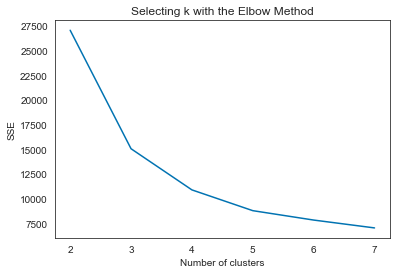

In [54]:
plt.plot(clusters, sse)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Selecting k with the Elbow Method')
plt.show()

By plotting the SSE for different k's, it shows that the elbow ocurrs around where k equals 3. We will thus use 3 clusters for our k-means algorithm. 

In [92]:
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(x_cols_norm)

In [93]:
print('0: ', sum(labels==0))
print('1: ', sum(labels==1))
print('2: ', sum(labels==2))

0:  1318236
1:  335157
2:  133363


##### Visualizing Clusters Using PCA

Now we have the clusters predicted from k-means, we can visualize the data using PCA and colored by cluster number. 

In [94]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x_cols_norm)
pca_features = pca.transform(x_cols_norm)

In [95]:
x = [item[0] for item in pca_features]
y = [item[1] for item in pca_features]
d = {"donor_id": donation_per_user.index, "cluster_id": labels, "x": x, "y": y}
df_pca = pd.DataFrame(d)
print(df_pca.head())

   cluster_id                          donor_id         x         y
0           2  ba7d4afdfc182c4c5fde1d57980697bc  0.823809 -0.225622
1           2  9b29654e7ea1241e6fa1ec4805b7429e  0.810489 -0.205557
2           2  b8f54362e335b81171ebbe36c657ea4b  0.731660 -0.113302
3           2  c91489d7b6b89943a28555e6add72509  0.655606  0.000276
4           2  5551a5dab1369830dcc872c8e295009a  0.796082 -0.174759


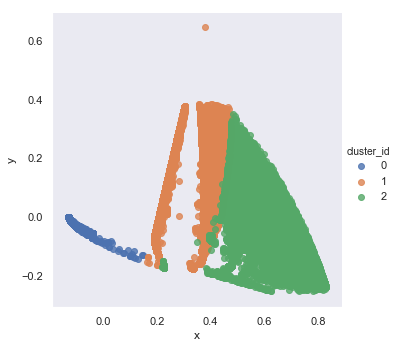

In [96]:
sns.set_style('dark')
sns.lmplot(x="x", y="y", data=df_pca, hue="cluster_id", fit_reg=False)

Looking at the PCA plot, 3 clusters seem to be a good choice. The data points are well divided into 3 groups with clear boundaries. Now we have our 3 clusters, it's time to add the cluster numbers back to the original dataset for some further analysis. 

##### Add Clusters and PCA Features Back to Database

In [97]:
df_cluster = df_us.merge(df_pca, left_on='_donor_acctid', right_on='donor_id')
df_cluster.head()

,_donationid,_projectid,_donor_acctid,donor_city,donor_state,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,donation_total,payment_method,is_teacher_referred,thank_you_packet_mailed,_teacher_acctid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,teacher_prefix,primary_focus_subject,primary_focus_area,secondary_focus_subject,secondary_focus_area,resource_type,poverty_level,grade_level,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,total_donations,num_donors,eligible_double_your_impact_match,eligible_almost_home_match,funding_status,date_posted,date_completed,date_thank_you_packet_mailed,date_expiration,donor_state_population,project_year,complete_year,teacher_gender,cluster_id,donor_id,x,y
0,53ec9a692cd770d6e4f0c6673451ff60,69bf3a609bb4673818e0eebd004ea504,ba7d4afdfc182c4c5fde1d57980697bc,NaN,CA,0,2011-03-18 01:54:04.960,217.130005,38.320000,255.449997,double_your_impact_match,0,f,b023fd4d537d99f7cf728306b5377cea,6.123300e+10,38.463570,-121.422150,Sacramento,CA,95823.0,urban,Elk Grove Unif School District,Sacramento,Mrs.,Literature & Writing,Literacy & Language,Mathematics,Math & Science,Technology,highest poverty,Grades PreK-2,434.260010,510.890015,23.0,510.899994,4,t,f,completed,2011-01-23,2011-03-18,2011-05-10,2011-06-21,39296476.0,2011,2011.0,Female,2,ba7d4afdfc182c4c5fde1d57980697bc,0.823809,-0.225622
1,6d90d1176d75972053b2f122704bf353,ebbcd4dee5069e4caacbc38c99abaf0a,ba7d4afdfc182c4c5fde1d57980697bc,NaN,CA,0,2011-02-24 22:29:50.721,101.169998,17.850000,119.019997,double_your_impact_match,0,f,ee49eb8ef8963e2af126f95c6eb282f7,4.815270e+11,27.791668,-97.430534,Corpus Christi,TX,78408.0,urban,Corpus Christi Ind Sch Dist,Nueces,Ms.,Literacy,Literacy & Language,Literature & Writing,Literacy & Language,Technology,highest poverty,Grades 6-8,202.350006,238.059998,105.0,235.690002,9,t,f,completed,2011-02-20,2011-02-24,2011-05-31,2011-07-20,39296476.0,2011,2011.0,Female,2,ba7d4afdfc182c4c5fde1d57980697bc,0.823809,-0.225622
2,c1ecbb81a7329d54a72a65c28c44fafb,f17ec505112e73d642faff1055c1d606,ba7d4afdfc182c4c5fde1d57980697bc,NaN,CA,0,2011-01-26 21:55:59.220,117.459999,20.730000,138.190002,double_your_impact_match,0,t,ffe0082f0a7f6d855726df72b2c7886a,4.090600e+10,33.544788,-112.099457,Phoenix,AZ,85021.0,urban,Washington Elem Sch Dist 6,Maricopa,Mrs.,Literature & Writing,Literacy & Language,Civics & Government,History & Civics,Technology,highest poverty,Grades 6-8,234.919998,276.380005,130.0,275.149994,13,t,f,completed,2011-01-25,2011-01-26,2011-04-11,2011-06-23,39296476.0,2011,2011.0,Female,2,ba7d4afdfc182c4c5fde1d57980697bc,0.823809,-0.225622
3,001bd16148cbd5666988a60b957c5c83,6ee4e855b48631f825ba4617aa132ba6,ba7d4afdfc182c4c5fde1d57980697bc,NaN,CA,0,2011-03-09 14:00:34.914,455.029999,80.300003,535.330017,double_your_impact_match,0,f,b11c897eefb5d86ba4b27699d1ae9bbe,6.170400e+10,33.868649,-118.391403,Hermosa Beach,CA,90254.0,suburban,Hermosa Beach City Sch Dist,Los Angeles,Ms.,Environmental Science,Math & Science,Mathematics,Math & Science,Technology,low poverty,Grades PreK-2,910.059998,1070.660034,48.0,1070.660034,2,t,f,completed,2011-02-08,2011-03-09,2011-03-09,2011-07-06,39296476.0,2011,2011.0,Female,2,ba7d4afdfc182c4c5fde1d57980697bc,0.823809,-0.225622
4,65528cf932ecdb11cba1fe37ac075288,9b01a0e84d7732577a7188408b49fe7d,ba7d4afdfc182c4c5fde1d57980697bc,NaN,CA,0,2011-02-08 08:51:33.497,213.449997,37.669998,251.119995,double_your_impact_match,0,t,29e0ff46963962adcc014689cd9dfbad,4.502310e+11,34.857063,-82.439285,Greenville,SC,29611.0,suburban,Greenville Co School District,Greenville,Mr.,Literacy,Literacy & Language,Social Sciences,History & Civics,Technology,highest poverty,Grades 3-5,426.910004,502.250000,50.0,502.070007,23,t,f,completed,2011-02-05,2011-02-08,2011-03-18,2011-07-01,39296476.0,2011,2011.0,Male,2,ba7d4afdfc182c4c5fde1d57980697bc,0.823809,-0.225622


### Cluster Analysis

At this point, we have a dataset where each row is a single donation from a single donor. Each donation is marked by a cluster number to indicate from which donor group the donation comes from. The below analysis replicates some of the analysis from EDA, but are broken down with added cluster information.

##### Number of Donors & Donations in Each Cluster

In [98]:
## number of donors in each cluster
donor_count_cl = df_cluster.groupby('cluster_id')['_donor_acctid'].nunique()
print('Number of Donors in Each Cluster')
print(donor_count_cl)

Number of Donors in Each Cluster
cluster_id
0    1318236
1     335157
2     133363
Name: _donor_acctid, dtype: int64


In [99]:
## number of donations in each cluster
cluster_count=df_cluster.groupby('cluster_id').size()
cluster_count.columns=['cluster_id', 'count']
print('Number of Donations from Each Cluster')
print(cluster_count)

Number of Donations from Each Cluster
cluster_id
0    1318236
1     759867
2    2541364
dtype: int64


Text(0.5, 1.0, 'Number of Donations from Each Cluster')

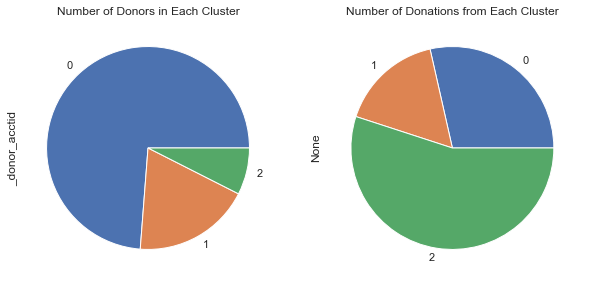

In [100]:
sns.set()
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
donor_count_cl.plot(kind='pie', ax=ax0)
cluster_count.plot(kind='pie', ax=ax1)
ax0.set_title('Number of Donors in Each Cluster')
ax1.set_title('Number of Donations from Each Cluster')

From above summary and pie charts, we can observe that cluster 0 is the largest group with the most donors. Cluster 2 is the smallest group. However, even though there is only a small portion of donors in cluster 2, they contributed to a large percentage of total number of donations. 

##### Donation Frequency

In [101]:
## donation frequency
donation_count = df_cluster.groupby('_donor_acctid').agg({'cluster_id': 'max', 
                                                          '_donor_acctid': 'count'}).reindex_axis(['cluster_id', 
                                                                                                   '_donor_acctid'], axis=1)
donation_count.columns=['cluster_id', 'donation_frequency']

In [102]:
mean_frequency = donation_count.groupby('cluster_id')['donation_frequency'].agg(['min', 'max', 'mean', 'median'])
mean_frequency = mean_frequency.reset_index()
#mean_frequency.columns = ['clusters', 'min', 'max', 'mean']
mean_frequency.head()

,cluster_id,min,max,mean,median
0,0,1,1,1.000000,1
1,1,1,41,2.267197,2
2,2,1,117096,19.055990,6


(0, 50)

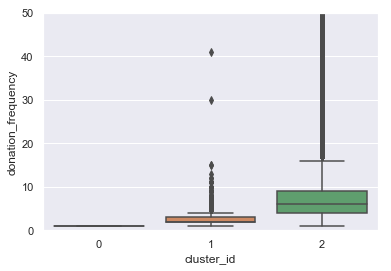

In [103]:
sns.boxplot(x='cluster_id', y='donation_frequency', data=donation_count)
plt.ylim(0,50)

After calculating some stats on how frequent the donors donate in each group, we notice that all the donors in cluster 0 are single-time donors. Donors in cluster 2 on average donated 19 times each person. This is the cluster with the highest donation retention. Majority of donors in cluster 1 donated between 2-4 times as shown below.

In [104]:
cluster_1 = donation_count[donation_count['cluster_id']==1]['donation_frequency']
cluster_1.value_counts().head(5)

2    250698
3     80460
4      3340
5       445
6       123
Name: donation_frequency, dtype: int64

##### Donation Amount

In [105]:
donation_amt = df_cluster.groupby('cluster_id')['donation_total'].agg(['count', 'sum','mean', 'median', 'std'])
donation_amt

,count,sum,mean,median,std
cluster_id,,,,,
0,1318236,62884352.0,47.703407,25.0,203.597839
1,759867,41835660.0,55.056553,25.0,181.591827
2,2541364,258153008.0,101.580490,25.0,341.177429


In [106]:
large_donors = df_cluster[df_cluster['donation_total']>10000]
large_donors['cluster_id'].value_counts()

2    218
0     16
1     14
Name: cluster_id, dtype: int64

In terms of donation amount, all the groups have a median donation of `$`25 dollars, while donors in cluster 2 have the highest average donation amount. When we filter for the donations that are higher than `$`10,000, most of them are from cluster 2. We can also visualize the distribution of a sample of the donations as below.

In [107]:
indiv_donor_amt = df_cluster.groupby('_donor_acctid').agg({'cluster_id': 'max', 
                                                           'donation_total': 'mean'}).reindex_axis(['cluster_id',
                                                                                                   'donation_total'], axis=1)
indiv_donor_amt.columns=['cluster_id','average_donation']
donation_ct_amt = donation_count.merge(indiv_donor_amt, left_index=True, right_index=True)

(0, 550)

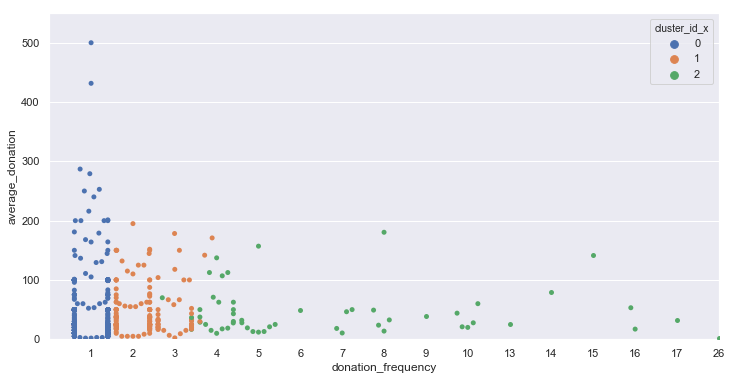

In [108]:
dca_sample = donation_ct_amt.sample(frac=0.0005)
plt.figure(figsize=(12,6))
sns.swarmplot(x='donation_frequency', y='average_donation', data=dca_sample, hue='cluster_id_x')
plt.xlim(-1, 15)
plt.ylim(0,550)

Again, we discover that most people from cluster 2 donated more than 4 times.

##### Donors by States

Next, we will visualize the geographic distribution of the donors on a map. To speed up the loading of the map, only a sample of the data points are shown on the visualization. 

In [109]:
import plotly

In [110]:
df_sample = df_cluster.sample(frac=0.0005)
scl = [ [0,"rgb(255, 153, 51)"],[0.5,"rgb(160, 160, 160)"],[1,"rgb(153, 204, 255)"] ]
data = [dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sample['school_longitude'],
        lat = df_sample['school_latitude'],
        #locations = df_sample['donor_state'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=1,
                color='rgba(102, 102, 102)'
            ),
            colorscale = scl,
            cmin = df_sample['cluster_id'].min(),
            color = df_sample['cluster_id'],
            cmax = df_sample['cluster_id'].max(),
            colorbar=dict(
                title="Clusters"
            )
        ))]

In [111]:
layout = dict(
        title = 'Donations in US Schools by Donor Clusters',
        colorbar = False,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

plotly.offline.init_notebook_mode(connected=True)
fig = dict( data=data, layout=layout )
plotly.offline.iplot(fig, validate=False)

From reading the map, we can see that donors from different clusters are spreaded out across the country with concentration on the east coast and California and Washington states on the west coast. 

##### Donation Counts by States

In [112]:
donor_state_grp = df_cluster.groupby(['donor_state', 'cluster_id'])['_donor_acctid'].count()
donor_state_grp = donor_state_grp.unstack('cluster_id')
donor_state_grp['sum'] = donor_state_grp.sum(axis=1)
donor_state_grp = donor_state_grp.sort_values('sum', ascending=False)#.reset_index()
donor_state_grp.head()

cluster_id,0,1,2,sum
donor_state,,,,
CA,281104,151885,436936,869925
NY,93173,65772,598248,757193
IL,65698,43394,230759,339851
FL,81223,50554,97280,229057
TX,75401,39793,90752,205946


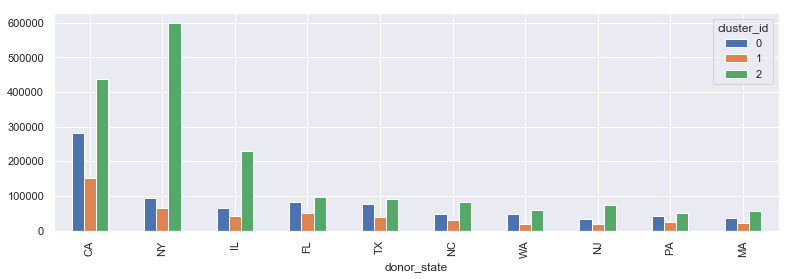

In [113]:
sns.set_palette('deep')
donor_state_grp_plt = donor_state_grp.iloc[:, 0:3]
donor_state_grp_plt = donor_state_grp_plt.head(10)
#donor_state_grp_plt.head(3)
fig, ax = plt.subplots(figsize=(13, 4))
donor_state_grp_plt.plot(kind='bar', ax=ax)

We've already known from the EDA that California, New York, and Illinois have the most number of donations. It is easily perceived that these three states have a relatively higher percentage of donors from cluster 2 compared to other states. This is most noticeable with New York. 

##### Donation Amount by State

In [114]:
donation_by_state = df_cluster.groupby(['donor_state', 'cluster_id'])['donation_total'].sum()
donation_by_state = donation_by_state.unstack('cluster_id')
donation_by_state['sum'] = donation_by_state.sum(axis=1)
donation_by_state = donation_by_state.sort_values('sum', ascending=False).reset_index()
donation_by_state.head()

cluster_id,donor_state,0,1,2,sum
0,CA,11822394.00,8235357.00,63529980.0,83587728.0
1,NY,5206392.50,4165359.75,63363068.0,72734816.0
2,IL,3261335.25,2331653.00,15162337.0,20755324.0
3,TX,4060607.25,2457561.50,7033540.5,13551710.0
4,FL,3593194.50,2354056.50,6347023.0,12294274.0


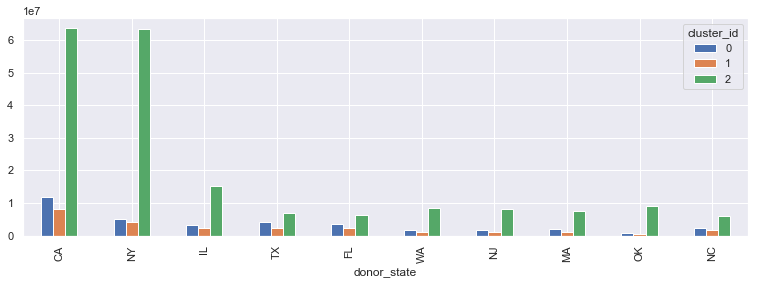

In [115]:
fig, ax = plt.subplots(figsize=(13, 4))
donation_by_state.iloc[0:10, 0:4].plot(x='donor_state', kind='bar', ax=ax)

Similar results appear as we look at the donation amount from each state. California, New York, and Illinois also have the highest amount of donations among all US states. This was probably also driven by the large donations from donors in cluster 2.

##### Donations vs. Thank You Packets

For some projects, the teachers will encourage the students to write and send a thank you letter to the donors after the project is completed. We would like to see if this gesture has an influence on the donors' behavior.

In [116]:
## thank_you_packet
thank_you = df_cluster.groupby(['cluster_id', 'thank_you_packet_mailed']).size()#.set_index('thank_you_packet_mailed')
thank_you = thank_you.unstack('thank_you_packet_mailed')
thank_you.columns.name=None
thank_you.columns = ['f', 't']

def cal_percent(row):
    return (row['t']/row['f'])

thank_you['perc'] = thank_you.apply(cal_percent, axis=1)
thank_you

,f,t,perc
cluster_id,,,
0,1204026,114210,0.094857
1,685014,74853,0.109272
2,2182238,359126,0.164568


According to the above chart, group 2 received the most percentage of thank you cards. That's probably why they are more motivated. 

##### Donors vs. Teacher Account

Some teachers are acting as donors to make contribution to their own or other teachers' projects. The below table and chart show the difference of composition of teacher and non-teacher donors in each cluster. 

In [117]:
teacher_acct = df_cluster[['_donor_acctid', 'cluster_id', 'is_teacher_acct']].drop_duplicates()
teacher_count = teacher_acct.groupby(['cluster_id','is_teacher_acct']).size()
teacher_count = teacher_count.unstack('cluster_id')
teacher_count.columns.name=None
teacher_count.index = ['Not Teacher', 'Teacher']
teacher_count = teacher_count.div(teacher_count.sum())
#def cal_percent(row):
    #return (row['t']/(row['f']+row['t']))

#teacher_count['perc'] = teacher_count.apply(cal_percent, axis=1)

teacher_count = teacher_count.transpose()
teacher_count

,Not Teacher,Teacher
0,0.955708,0.044292
1,0.899838,0.100162
2,0.820175,0.179825


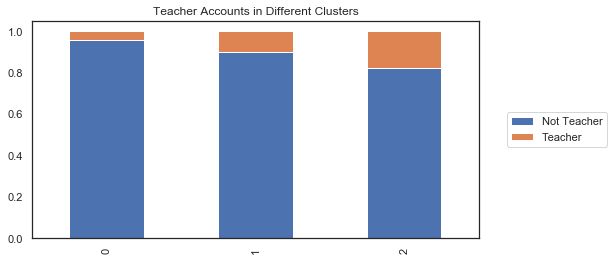

In [118]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(8,4))
teacher_count.plot(kind='bar', stacked=True, ax=ax, title='Teacher Accounts in Different Clusters')
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))

Overall, teacher account doesn't compose a big share of all donors. Cluster 2 has the highest percentage of teacher account as donors, while clusters 0, which consists mostly single-time donors, has the lowest fraction of teacher account. 

In [119]:
teachers = df_cluster[df_cluster['is_teacher_acct']==1]
teacher_mean = teachers.groupby('_donor_acctid').size().mean()
print('On average, donors with a teacher account donated', round(teacher_mean, 2), 'times per person.')

On average, donors with a teacher account donated 5.73 times per person.


##### Donations vs. Grade Level

In [120]:
df_grades = df_cluster.groupby(['grade_level', 'cluster_id']).size()
df_grades = df_grades.unstack('cluster_id')
df_grades

cluster_id,0,1,2
grade_level,,,
Grades 3-5,410362,238357,813930
Grades 6-8,230596,129668,412420
Grades 9-12,194655,105331,334884
Grades PreK-2,482564,286484,980048


Text(0, 0.5, '')

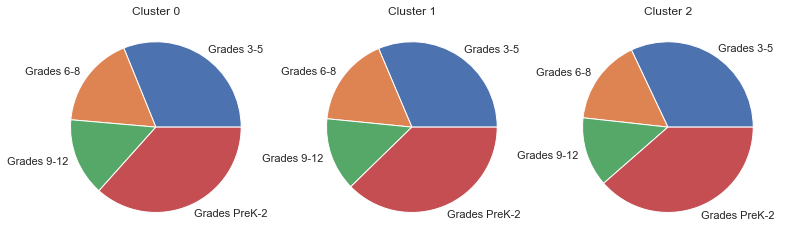

In [121]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(13,4))
df_grades[0].plot(kind='pie', ax=ax0,)
ax0.set_title('Cluster 0')
ax0.set_ylabel('')
df_grades[1].plot(kind='pie', ax=ax1)
ax1.set_title('Cluster 1')
ax1.set_ylabel('')
df_grades[2].plot(kind='pie', ax=ax2)
ax2.set_title('Cluster 2')
ax2.set_ylabel('')

When looking at the donation into different grade levels, the 3 clusters share very similar pattern. Most of the contributions went into elementary schools.

##### Donations vs. Poverty Level

In [122]:
poverty = df_cluster.groupby(['cluster_id', 'poverty_level']).size()
poverty = poverty.unstack('cluster_id')
poverty

cluster_id,0,1,2
poverty_level,,,
high poverty,341105,184045,632815
highest poverty,695126,421474,1500669
low poverty,48351,26981,61214
moderate poverty,233654,127367,346666


In [123]:
poverty = poverty.div(poverty.sum())

Text(0.5, 0, 'Clusters')

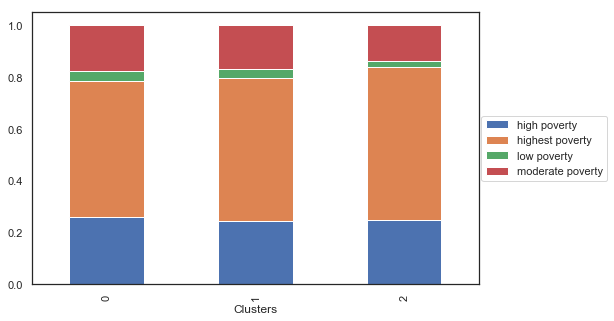

In [124]:
fig, ax = plt.subplots(figsize=(8,5))
poverty.T.plot(kind='bar', stacked=True, ax=ax)
ax.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
ax.set_xlabel('Clusters')

As shown in the above graph, the three groups also show similar behavior when donating into projects from regions with different poverty level. Donors in cluster 2 made a slightly higher percentage of donations in the highest poverty category.

##### Donations vs. Project Type

From EDA analysis we have known that among all the project focus areas, Literacy & Language and Math & Science are the two hottest categories that received the most funding. We are curious if any particular pattern would be observed among different clusters.

In [125]:
subject = df_cluster.groupby(['cluster_id', 'primary_focus_area']).size()#.set_index('thank_you_packet_mailed')
subject = subject.unstack('primary_focus_area')
subject

primary_focus_area,Applied Learning,Health & Sports,History & Civics,Literacy & Language,Math & Science,Music & The Arts,Special Needs
cluster_id,,,,,,,
0,81019,49879,54093,571546,341889,125985,93781
1,47864,26750,31835,331621,193697,75602,52478
2,169018,113150,110180,1045376,651664,282351,169524


Text(0.5, 0, '')

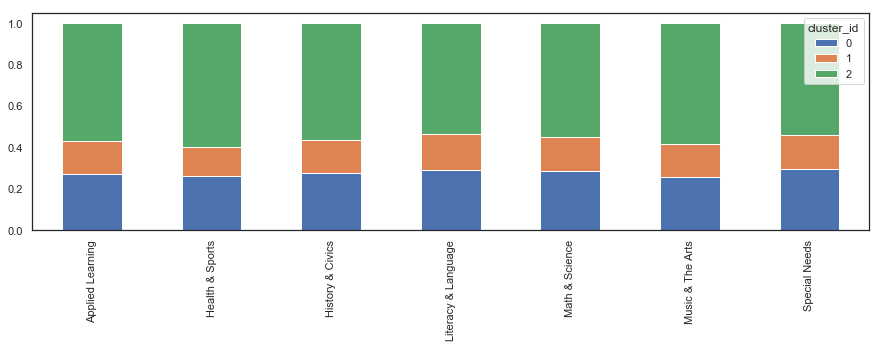

In [126]:
subject = subject.div(subject.sum())
fig, ax = plt.subplots(figsize=(15,4))
subject.T.plot(kind='bar', ax=ax, stacked=True)
ax.set_xlabel('')

As depicted in the above graph, donors from all 3 clusters are indifferent in choosing the project subject. Each subject has a similar proportion of donors from each cluster.

### Observations  from Clustering

* The donors are clustered into 3 groups.
* Group 0 has the largest number of donors and Group 2 has the least number of donors.
* Even though Group 2 has the least number of donors, they contributed to the largest percentage of total number of donations.
* Group 0 are all single-time donors and Group 2 consists of many frequent donors.
* All the groups have a median donation of `$`25 dollars, while donors in Group 2 have the highest average donation amount. For all the donations exceeding `$`10,000, most of them are from Group 2 donors.
* Geographically, donors in all 3 groups scatter across US. Most of the donors come from east coast and California and Washington on the west coast.
* New York has the largest proportions of donations from Group 2 compared to other states.
* Group 2 received the most percentage of thank you letters amongst all three groups.
* Cluster 2 has the highest percentage of teacher account as donors, while clusters 0, which consists mostly single-time donors, has the lowest fraction of teacher account. 
* Donors in Group 2 made a slightly higher percentage of donations in the highest poverty category.
* All 3 clusters exhibit similar donation behavior in terms of choosing projects from different grade levels, poverty levels, and project subjects. 

### <font color=#3090C7>RECOMMENDATIONS</font>

 
* **Observations**: Donors from cluster 2 are the current main force that drive most of the donations on the platform. They tend to make repetitive contributions and are motivated to give relatively larger amount of financial support. <br><br> **Recommended Action Item**: This is the group that demonstrates the most desire to help. The client can further incentivize this group by recognizing their generosity from creating a recognition system such as a donor leaderboard or major donor badges or even offering special volunteering opportunities to them.     


* **Observations**: Group 2 received the most percentage of thank you letters amongst all three groups and is observed to contain most frequent donors.<br><br>**Recommended Action Item**: we have 74% of single-time donors on the platform. There exists an opportunity to motivate these people to make repetitive donations by sending more thank you packets to them. The client can deliver messages to the teachers after the project is completed and remind them to encourage the students to make some thank you cards or come up with other creative way to show their appreciation.     


* **Observations**: Most of the donations are concentrated in California, New York, and Illinois.<br><br>**Recommended Action Item**: It could be beneficial to increase the brand awareness of DonorsChoose in the regions that are currently underserved. We would suggest more marketing compaigns, partnership with local organizations and media, and using digital flyers such as Peachjar to increase brand recognition.    

### <font color=#3090C7>FUTURE WORK</font>

In the future, we could try different machine learning algorithms for the donor clustering to see which one generates the best result. Meanwhile, more analysis could be conducted on subjects such as how the projects are worded, how the thank you letters are written, and how the current campaigns are conducted. In order to identify the most efficient and effective campaigns and projects, we could also do A/B tests to help the analysis. 

When more analysis done, we could potentially build an integrated system to help teachers to write impressive project description, recommend the projects to the auto-paired potential donors, analyze the donation and send feedback to better improve the recommendation system. 